# 사이킷런으로 수행하는 타이타닉 생존자 예측

- PassengerID : 승객들 번호
- Survived : 생존 여부 (0 : 생존x , 1 : 생존0)
- Pclass : 티켓의 선실 등급 ( 1 : 일등석, 2 : 이등석, 3 : 삼등석)
- Sex : 탑승자 성별
- Name : 탑승자 이름
- Age : 탑승자의 나이
- Sibsp : 같이 탑승한 형제자매 또는 배우자 인원수
- Parch : 같이 탑승한 부모님 또는 자녀 인원수
- Ticket : 티켓번호
- Fare : 요금
- Cabin : 선실 번호
- Embarked : 중간 정착 항구 (C = Cherbourg, Q = Queenstown, S = Southampton)

## 데이터 및 라이브러리 로딩

분석에 필요한 라이브러리와 train.csv를 불러온다.

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

titanic_df = pd.read_csv("C:/Users/Edward/Desktop/PythonWorkspace/train.csv")
titanic_df.head(3)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


## 데이터 확인

In [19]:
print("\n ### 학습 데이터 정보 ###  \n")
print(titanic_df.info())


 ### 학습 데이터 정보 ###  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


RangeIndex는 DataFrame 인텍스의 범위를 나타내므로 전체 행 수를 알 수 있다.  
RangeIndex가 891entries이므로 891 개의 행으로 구성된다. 그리고 열의 갯수는 12개다.  
2개의 열이 float64, 5개의 열이 int64, 5개의 열이 object다.  
판다스의 object 타입은 string 타입으로 봐도 무방함.  
Age, Cabin. Embarked 칼럼은 각각 177개, 608개, 2개의 Null값(NaN)을 가지고 있음.  
사이킷런 머신러닝 알고리즘은 Null 값을 허용하지 않으므로 Null 값의 처리를 결정.  
여기서는 DataFrame의 fillna() 함수를 사용해 간단하게 Null 값을 평균 또는 고정 값으로 변경. 
Age의 경우는 평균 나이, 나머지 칼럼은 'N' 값으로 변경한다. 그 다음 다시 확인.

## 데이터 전처리

### 결측치 처리

In [20]:
titanic_df["Age"].fillna(titanic_df["Age"].mean(), inplace=True)
titanic_df["Cabin"].fillna("N", inplace = True)
titanic_df["Embarked"].fillna("N", inplace = True)
print("데이터 세트 null 값 개수", titanic_df.isnull().sum().sum())

데이터 세트 null 값 개수 0


### 문자열 변수 확인

In [21]:
print(" Sex 값 분포:\n", titanic_df["Sex"].value_counts())
print(" \n Cabin 값 분포:\n", titanic_df["Cabin"].value_counts())
print(" \n Embarked 값 분포:\n", titanic_df["Embarked"].value_counts())

 Sex 값 분포:
 male      577
female    314
Name: Sex, dtype: int64
 
 Cabin 값 분포:
 N              687
C23 C25 C27      4
G6               4
B96 B98          4
C22 C26          3
              ... 
E34              1
C7               1
C54              1
E36              1
C148             1
Name: Cabin, Length: 148, dtype: int64
 
 Embarked 값 분포:
 S    644
C    168
Q     77
N      2
Name: Embarked, dtype: int64


Sex, Embarked 값은 문제가 없으나, Cabin은 N이 687건으로 가장 많음, 선실을 못 산 입석으로 봐도 무방, 그리고 속성값이 제대로 정리가 되지 않음. 예를 들어 'C23 C25 C27'과 같이 여러 Cabin이 한꺼번에 표기된 Cabin 값이 4건. Cabin의 경우 선실 번호 중 선실 등급을 나타내는 첫 번째 알파벳이 객실 등급을 나누는 중요한 값으로 보임. 따라서 Cabin의 앞 문자만 추출.

### 문자열 변수 가공

In [22]:
titanic_df["Cabin"] = titanic_df["Cabin"].str[:1]
print(titanic_df["Cabin"].head(3))

0    N
1    C
2    N
Name: Cabin, dtype: object


In [23]:
titanic_df.groupby(['Sex','Survived'])['Survived'].count()

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64

## 데이터 EDA

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

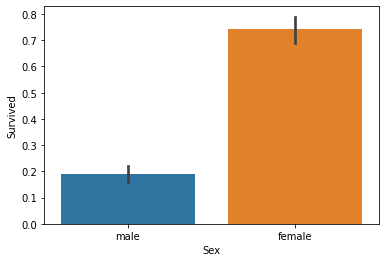

In [24]:
sns.barplot(x = 'Sex', y = 'Survived', data = titanic_df)

남성보다 여성의 생존율이 높음

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

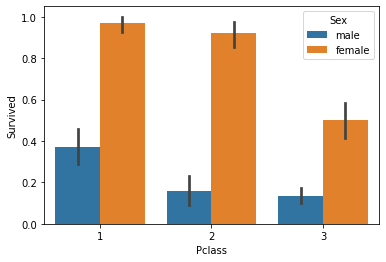

In [25]:
sns.barplot(x = 'Pclass', y = 'Survived', data = titanic_df, hue = 'Sex')

1등급의 선실에 있는 사람들이 가장 많이 생존, 모든 등급의 객실에서 여성의 생존율이 높음

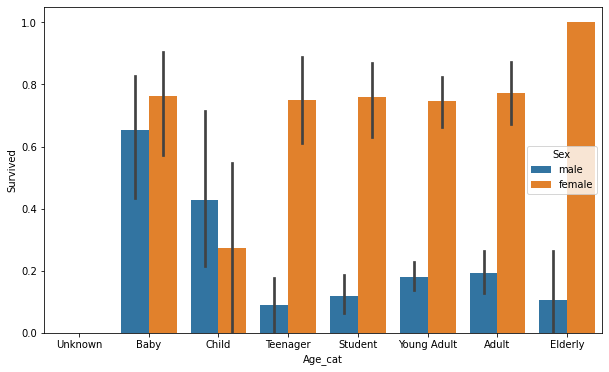

In [26]:
# 입력 age에 따라 구분 값을 반환하는 함수 설정 dataframe의 apply lambda 식에 사용
def get_category(age):
  cat = ''
  if age <= -1 : cat = 'Unknown'
  elif age <= 5 : cat = 'Baby'
  elif age <= 12 : cat = 'Child'
  elif age <= 18 : cat = 'Teenager'
  elif age <= 25 : cat = 'Student'
  elif age <= 35 : cat = 'Young Adult'
  elif age <= 60 : cat = 'Adult'
  else : cat = 'Elderly'

  return cat

# 막대그래프의 크기 figure를 더 크게 설정
plt.figure(figsize=(10,6))

# x축의 값을 순차적으로 표시하기 위한 설정
group_names = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Elderly']

# lambda 식에 위에서 생성한 get_category() 함수를 반환값으로 지정.
# get_category(X)는 입력값으로 'Age' 칼럼 값을 받아서 해당하는 cat 변환
titanic_df['Age_cat'] = titanic_df['Age'].apply(lambda x : get_category(x))
sns.barplot(x= 'Age_cat', y= 'Survived', hue= 'Sex', data= titanic_df, order= group_names)
titanic_df.drop('Age_cat', axis= 1, inplace= True)

나이에 따라 bin을 할당하여 Age_cat 생성  
각각 x, y축을 할당하고, 범례도 생성함  
아이와 여성 노인 같은 취약계층이 생존율이 높음

### 라벨 인코딩

In [27]:
from sklearn.preprocessing import LabelEncoder

def encode_features(dataDF):
  features = ['Cabin', 'Sex','Embarked']
  for feature in features:
    le = LabelEncoder( )
    le = le.fit(dataDF[feature])
    dataDF[feature] = le.transform(dataDF[feature])

  return dataDF

titanic_df = encode_features(titanic_df)
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,7,3
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,2,0
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,7,3
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,2,3
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,7,3


앞에서 서술 했듯 사이킷런은 데이터에 문자열을 사용 못하므로 라벨 인코딩을 진행.

### 함수 생성

In [28]:
# Null 처리 함수
def fillna(df):
  df['Age'].fillna(df['Age'].mean(), inplace = True)
  df['Cabin'].fillna('N', inplace = True)
  df['Embarked'].fillna('N', inplace = True)
  df['Fare'].fillna(0, inplace = True)
  return df

# 머신러닝 알고리즘에 불필요한 변수 제거
def drop_features(df):
  df.drop(['PassengerId', 'Name', 'Ticket'], axis = 1, inplace = True)
  return df

# 레이블 인코딩 수행.
def format_features(df):
  df['Cabin'] = df['Cabin'].str[:1]
  features = ['Cabin','Sex','Embarked']
  for feature in features:
    le = LabelEncoder()
    le = le.fit(df[feature])
    df[feature] = le.transform(df[feature])
  return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
  df = fillna(df)
  df = drop_features(df)
  df = format_features(df)
  return df

여태의 변수 가공내역을 함수로 생성하여 재사용이 가능케 함. 불필요한 식별자 변수는 제거.

## 데이터 분리

In [29]:
# 원본 데이터를 재로딩하고, 변수 데이터 세트와 라벨 데이터 세트 추출.
titanic_df = pd.read_csv("C:/Users/Edward/Desktop/PythonWorkspace/train.csv")
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1)

X_titanic_df = transform_features(X_titanic_df)

In [30]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train , y_test = train_test_split(X_titanic_df, y_titanic_df, test_size = 0.2, random_state = 11)

## 모델링

In [31]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

# 결정트리, 랜포, 로지스틱 회귀를 위한 사이킷런 Classifier 클래스 생성
dt_clf = DecisionTreeClassifier(random_state = 11)
rf_clf = RandomForestClassifier(random_state = 11)
lr_clf = LogisticRegression(solver = 'liblinear')

# DecisionTreeClassifier 학습/예측/평가
dt_clf.fit(X_train, y_train)
dt_pred = dt_clf.predict(X_test)
print('DecisionTreeClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, dt_pred)))

# RandomForestClassifier 학습/예측/평가
rf_clf.fit(X_train, y_train)
rf_pred = rf_clf.predict(X_test)
print('RandomForestClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, rf_pred)))

# LogisticRegressionClassifier 학습/예측/평가
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)
print('LogisticRegressionClassifier 정확도:{0:.4f}'.format(accuracy_score(y_test, lr_pred)))

DecisionTreeClassifier 정확도:0.7877
RandomForestClassifier 정확도:0.8547
LogisticRegressionClassifier 정확도:0.8659


## 교차 검증

In [32]:
from sklearn.model_selection import KFold

def exec_kfold(clf, folds = 5):
  # 폴드 세트를 5개인 KFold 객체를 생성, 폴드 수만큼 예측결과 저장을 위한 리스트 객체 생성.
  kfold = KFold(n_splits = folds)
  scores = []

  # KFold 교차검증 수행.
  for iter_count, (train_index, test_index) in enumerate(kfold.split(X_titanic_df)):
    # X_titanic_df 데이터에서 교차 검증별로 학습과 검증 데이터를 가리키는 index 생성
    X_train, X_test = X_titanic_df.values[train_index], X_titanic_df.values[test_index]
    y_train, y_test = y_titanic_df.values[train_index], y_titanic_df.values[test_index]
    # Classifier 학습, 예측, 정확도 계산
    clf.fit(X_train, y_train)
    predictions = clf.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    scores.append(accuracy)
    print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

  # 5개 fold에서의 평균 정확도 계산.
  mean_score = np.mean(scores)
  print("평균 정확도: {0:.4f}".format(mean_score))
# exec_kfold 호출
exec_kfold(dt_clf, folds = 5)

교차 검증 0 정확도: 0.7542
교차 검증 1 정확도: 0.7809
교차 검증 2 정확도: 0.7865
교차 검증 3 정확도: 0.7697
교차 검증 4 정확도: 0.8202
평균 정확도: 0.7823


In [33]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(dt_clf, X_titanic_df, y_titanic_df, cv= 5)

for iter_count, accuracy in enumerate(scores):
  print("교차 검증 {0} 정확도: {1:.4f}".format(iter_count, accuracy))

print("평균 정확도: {0:.4f}".format(np.mean(scores)))

교차 검증 0 정확도: 0.7430
교차 검증 1 정확도: 0.7753
교차 검증 2 정확도: 0.7921
교차 검증 3 정확도: 0.7865
교차 검증 4 정확도: 0.8427
평균 정확도: 0.7879


## 그리드서치

In [34]:
from sklearn.model_selection import GridSearchCV

parameters = {'max_depth':[2, 3, 5, 10],
              'min_samples_split':[2, 3, 5], 'min_samples_leaf':[1, 5, 8]}

grid_dclf = GridSearchCV(dt_clf, param_grid = parameters, scoring = 'accuracy', cv= 5)
grid_dclf.fit(X_train, y_train)

print('GridSearchCV 최적 하이퍼 파라미터:', grid_dclf.best_params_)
print('GridSearchCV 최고 정확도: {0:.4f}'.format(grid_dclf.best_score_))
best_dclf = grid_dclf.best_estimator_

# GridSearchCV의 최적 하이퍼 파라미터로 학습된 Estimator로 예측 및 평가 수행.
dpredictions = best_dclf.predict(X_test)
accuracy = accuracy_score(y_test, dpredictions)
print("테스트 세트에서의 DecisionTressClassifier 정확도 : {0:.4f}".format(accuracy))

GridSearchCV 최적 하이퍼 파라미터: {'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}
GridSearchCV 최고 정확도: 0.7992
테스트 세트에서의 DecisionTressClassifier 정확도 : 0.8715
